# BigQuery-Geotab Intersection Congestion

We’ve all been there: Stuck at a traffic light, only to be given mere seconds to pass through an intersection, behind a parade of other commuters. Imagine if you could help city planners and governments anticipate traffic hot spots ahead of time and reduce the stop-and-go stress of millions of commuters like you.

# Table of contents
- [Imports and initial exploration](#imports)

- [Exploratory Data Analysis](#eda)
    - [Time features](#hmw)
    - [Exploring street features](#streetfeatures)
    - [Latitude and Longitude](#latlon)
    
- [Preprocessing](#prepro)

- [Baseline model](#baseline)

## Imports and initial exploration
<a id='imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplleaflet
from collections import Counter

import json

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tensorflow import keras

from mlxtend.regressor import StackingRegressor

sns.set_style('darkgrid')
sns.set_palette('deep')

In [2]:
train = pd.read_csv('../input/bigquery-geotab-intersection-congestion/train.csv')
test = pd.read_csv('../input/bigquery-geotab-intersection-congestion/test.csv')
sample = pd.read_csv('../input/bigquery-geotab-intersection-congestion/sample_submission.csv')
with open('../input/bigquery-geotab-intersection-congestion/submission_metric_map.json') as f:
    submission_metric_map = json.load(f)

## Exploratory Data Analysis
<a id='eda'></a>

### Time features
<a id='hmw'></a>

We all know there is probably a high correlation between the time features and the  values we want to predict, let's visualize this interaction

In [3]:
time_features = ['Hour', 'Month', 'Weekend']

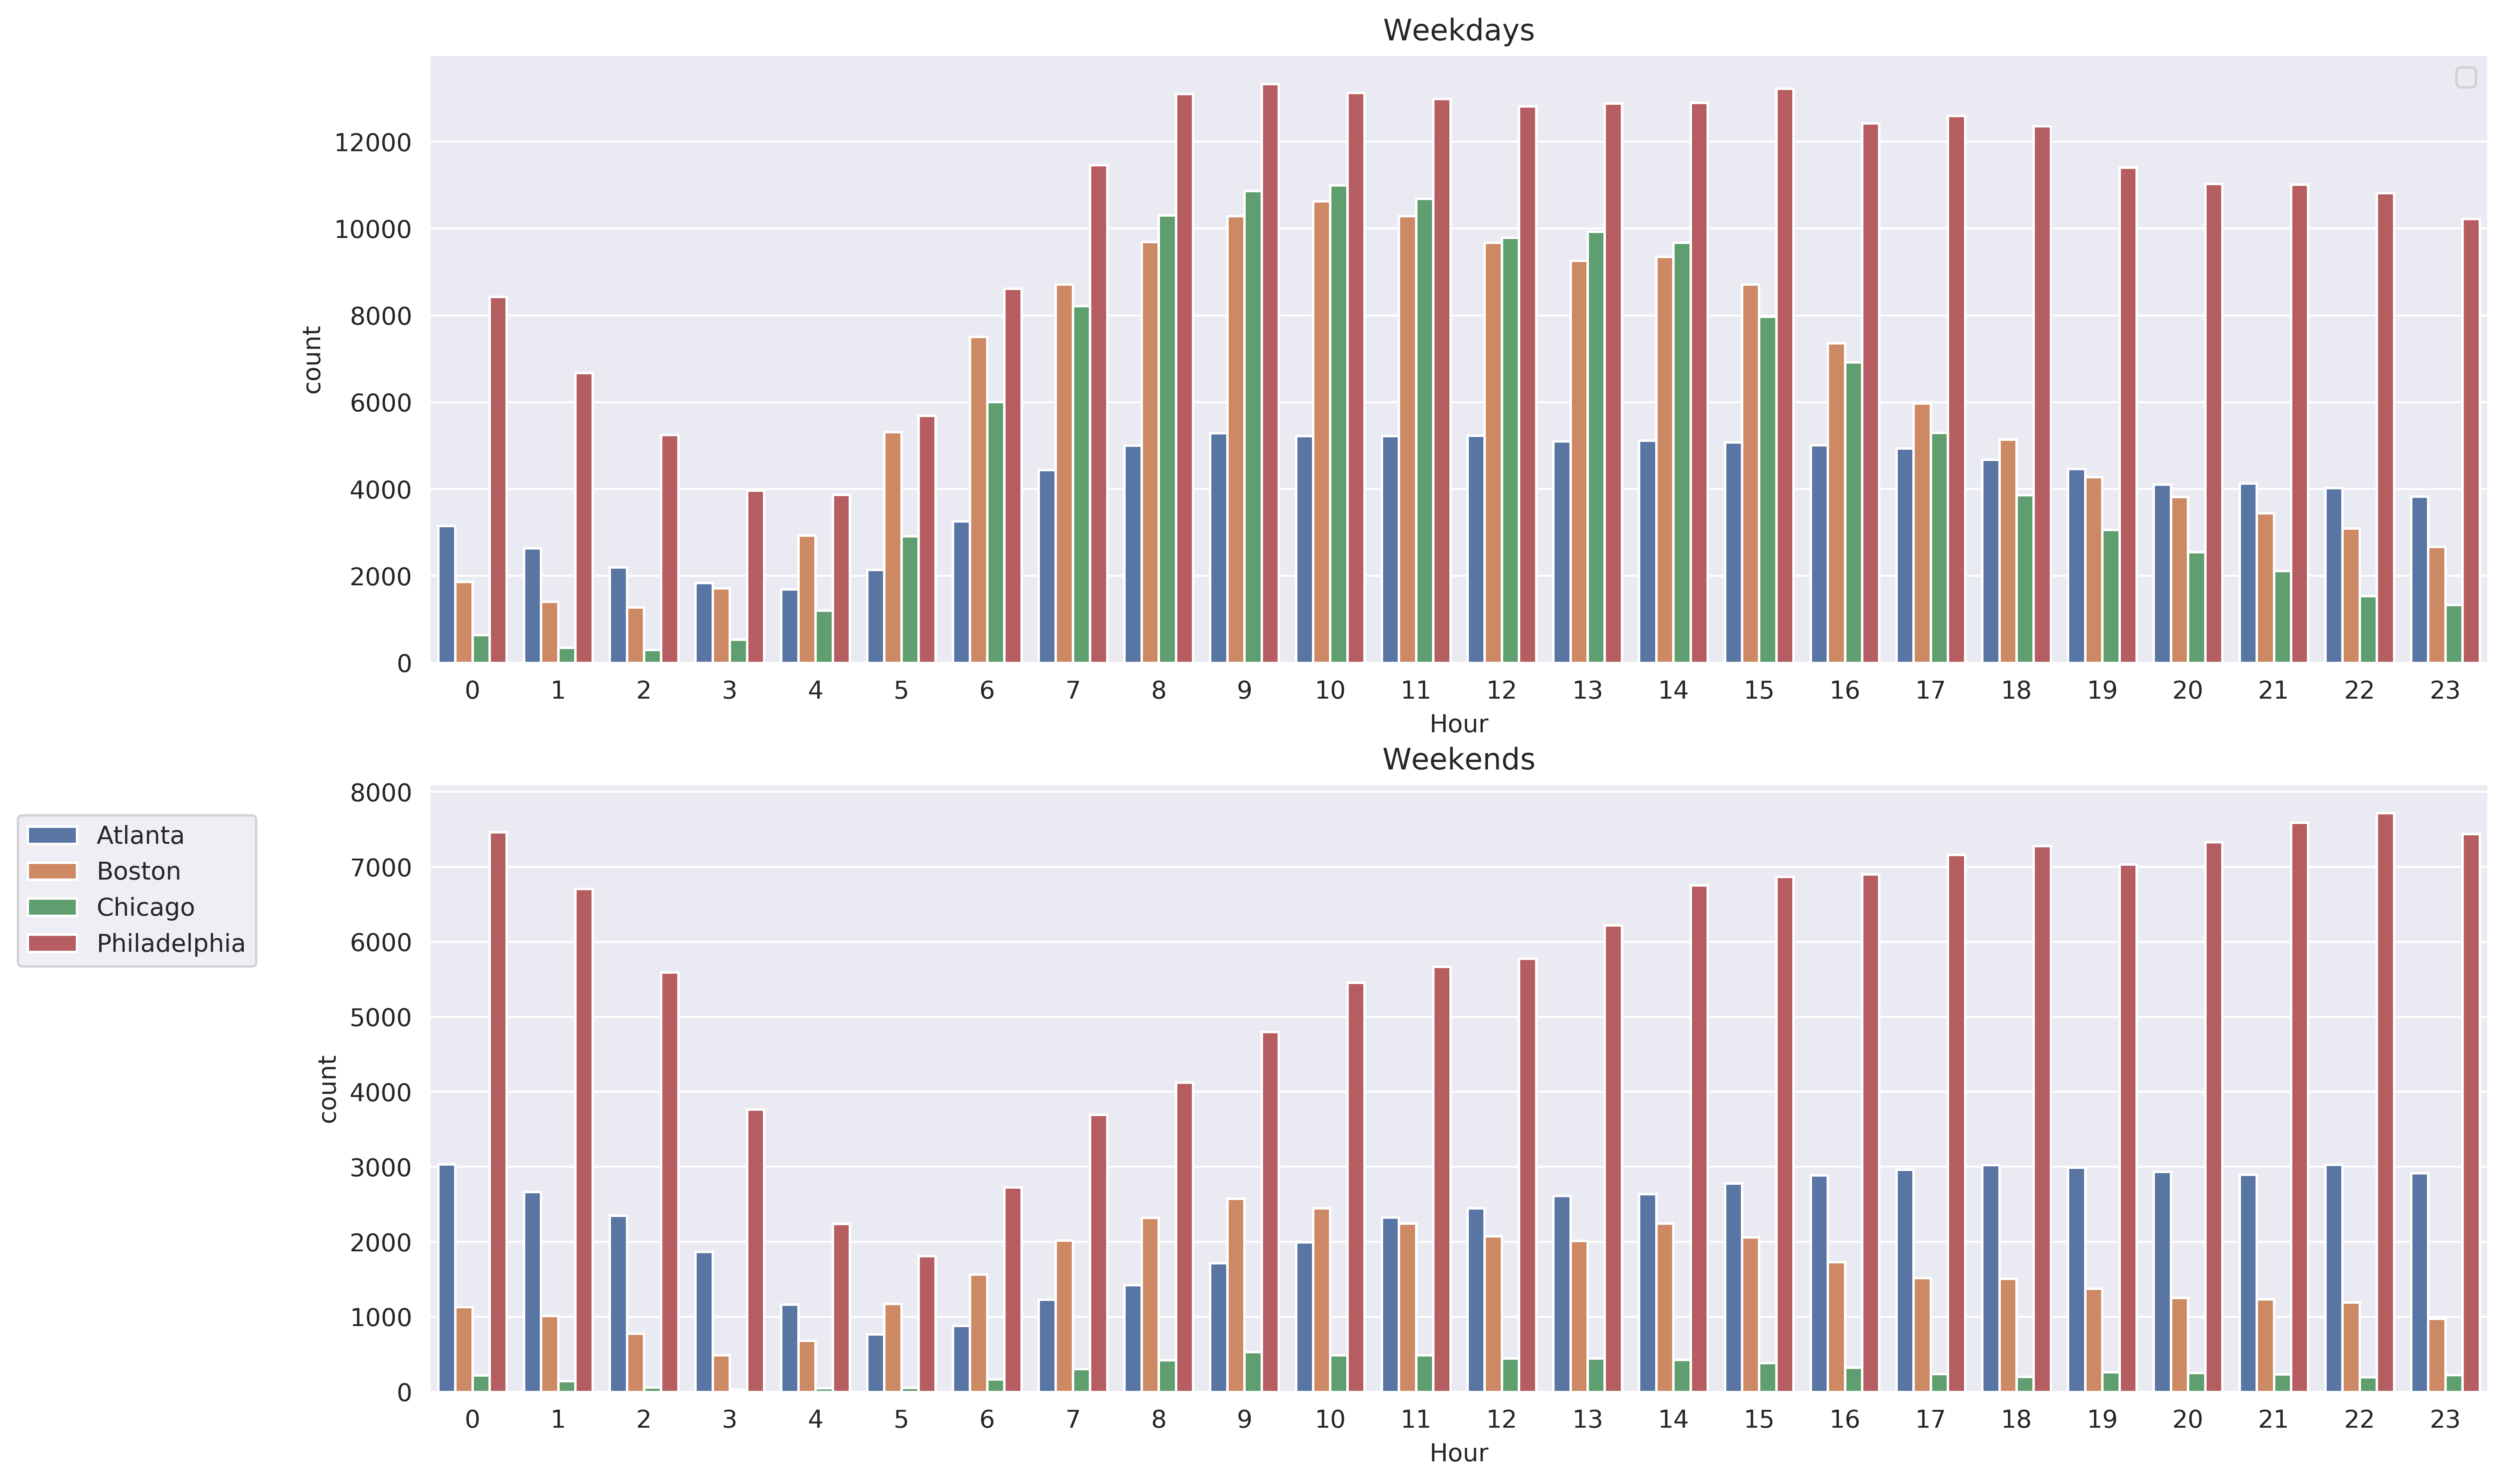

In [4]:
fig, axes = plt.subplots(2,1, figsize=[15,10])

sns.countplot(data=train[train['Weekend']==0], hue='City', x='Hour', ax=axes[0],);
sns.countplot(data=train[train['Weekend']==1], hue='City', x='Hour', ax=axes[1]);
axes[0].legend([])
axes[1].legend(loc=[-0.2,0.7])
axes[0].set_title("Weekdays")
axes[1].set_title("Weekends")
fig.set_dpi(500)

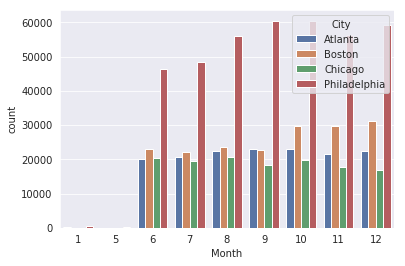

In [5]:
sns.countplot(x='Month', hue='City', data=train)

### Exploring street features
<a id='streetfeatures'></a>

In [6]:
street_features = ['EntryStreetName', 'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Path']

We can see clearly path is just a concatenation of the other features, so we can just drop it

In [7]:
train.drop('Path', axis=1, inplace=True)
test.drop('Path', axis=1, inplace=True)

The cardinal directions can be expressed using the following equation:
$$
\frac{\theta}{\pi}
$$
Where $\theta$ is the angle between the we want to encode direction and the north direction measured clockwise

In [8]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [9]:
train['EntryHeading'] = train['EntryHeading'].map(directions)
train['ExitHeading'] = train['ExitHeading'].map(directions)

In [10]:
test['EntryHeading'] = test['EntryHeading'].map(directions)
test['ExitHeading'] = test['ExitHeading'].map(directions)

In [11]:
train['diffHeading'] = (train['ExitHeading']-train['EntryHeading'])
test['diffHeading'] = (test['ExitHeading']-test['EntryHeading'])

### Looking at street names

In [12]:
word_count = Counter()
for name in train['EntryStreetName']:
    if pd.isna(name):
        continue
    for word in name.split():
        word_count[word]+=1
        
for name in train['ExitStreetName']:
    if pd.isna(name):
        continue
    for word in name.split():
        word_count[word]+=1

Let's use the following road types: Street, Avenue, Road, Boulevard, Broad and Drive

After searching on the <a href='https://360.here.com/2016/12/30/whats-the-difference-between-a-road-a-street-and-an-avenue/'>internet</a> their differences, I found that Avenue and Street are basically the same thing.

a) Street (for any thoroughfare) 

b) Road (for any thoroughfare) 

c) Way (for major roads - also appropriate for pedestrian routes) 

d) Avenue (for residential roads) 

e) Drive (for residential roads) 

f) Grove (for residential roads) 

g) Lane (for residential roads) 

h) Gardens (for residential roads) subject to there being no confusion with any local open space 

i) Place (for residential roads) 

j) Crescent (for a crescent shaped road) 

k) Court/Close (for a cul-de-sac only) 

l) Square (for a square only) 

m) Hill (for a hillside road only) 

n) Circus (for a large roundabout) 

o) Vale (for residential roads) 

p) Rise (for residential roads) 

q) Row (for residential roads) 

r) Wharf (for residential roads) 

s) Mews (for residential roads) 

t) Mead (for residential roads) 

u) Meadow (for residential roads)

In [13]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 2.5,
    'Broad': 2.5,
    'Boulevard': 3
}

In [14]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

In [15]:
train['EntryType'] = train['EntryStreetName'].apply(encode)
train['ExitType'] = train['ExitStreetName'].apply(encode)
test['EntryType'] = test['EntryStreetName'].apply(encode)
test['ExitType'] = test['ExitStreetName'].apply(encode)

In [16]:
train['EqualStreets'] = (train['EntryStreetName']==train['ExitStreetName'])
test['EqualStreets'] = (test['EntryStreetName']==test['ExitStreetName'])

### Latitude and Longitude
<a id='latlon'></a>

In [17]:
plt.figure(figsize=[10,10])
tmp = train[train['City']=='Boston'].groupby(['Latitude', 'Longitude'])['RowId'].count().reset_index()
sns.kdeplot(tmp['Longitude'], tmp['Latitude'])

mplleaflet.display()

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Looking at the intersections at Boston we can see we have a clear downtown area, so let's create a standard scaler for each city in order to encode this insight

In [18]:
cities = train['City'].unique()
scalers_lat = {}
scalers_lon = {}
for city in cities:
    latitudes = np.array(train[train['City']==city]['Latitude']).reshape(-1,1)
    longitudes = np.array(train[train['City']==city]['Longitude']).reshape(-1,1)
    scalers_lat[city] = StandardScaler().fit(latitudes)
    scalers_lon[city] = StandardScaler().fit(longitudes)

In [19]:
train['Latitude'] = train.apply(lambda row: scalers_lat[row['City']].transform(np.array(row['Latitude']).reshape(1,1)), axis=1)
train['Longitude'] = train.apply(lambda row: scalers_lon[row['City']].transform(np.array(row['Longitude']).reshape(1,1)), axis=1)
test['Latitude'] = test.apply(lambda row: scalers_lat[row['City']].transform(np.array(row['Latitude']).reshape(1,1)), axis=1)
test['Longitude'] = test.apply(lambda row: scalers_lon[row['City']].transform(np.array(row['Longitude']).reshape(1,1)), axis=1)

## Preprocessing
<a id='prepro'></a>

Let's create a new dataframe with the new following features: TotaTimeStopped, DistanceToFirstStop and Percentile.

Creating a dataframe in the following way can enable us to use the percentile as a feature and can help us boost the model

In [20]:
new_train_columns = ['IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend', 'DistanceToFirstStop',
       'Month', 'TotalTimeStopped', 'Percentile', 'City', 'diffHeading', 'EntryType', 'ExitType', 'EqualStreets']

In [21]:
new_test_columns = ['IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Percentile', 'City', 'diffHeading', 'EntryType', 'ExitType', 'EqualStreets']

In [22]:
new_train = pd.DataFrame(columns=new_train_columns)

In [23]:
new_test = pd.DataFrame(columns=new_test_columns)

In [24]:
for per in [20, 40, 50, 60, 80]:
    new_df = train.copy()
    new_df['TotalTimeStopped'] = new_df['TotalTimeStopped_p'+str(per)]
    new_df['DistanceToFirstStop'] = new_df['DistanceToFirstStop_p'+str(per)]
    new_df['Percentile'] = pd.Series([per for _ in range(len(new_df))])
    new_df.drop(['TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'RowId'], axis=1,inplace=True)
    new_train = pd.concat([new_train, new_df], sort=True)

In [25]:
for per in [20, 50, 80]:
    new_df = test.copy()
    new_df['Percentile'] = pd.Series([per for _ in range(len(new_df))])
    new_test = pd.concat([new_test, new_df], sort=True)

In [26]:
new_train = pd.concat([new_train.drop('City', axis=1), pd.get_dummies(new_train['City'])], axis=1)

In [27]:
new_test = pd.concat([new_test.drop('City', axis=1), pd.get_dummies(new_test['City'])], axis=1)

In [28]:
new_train = new_train.reindex(sorted(new_train.columns), axis=1)
new_test = new_test.reindex(sorted(new_test.columns), axis=1)

In [29]:
new_test = new_test.sort_values(by=['RowId', 'Percentile'])

In [30]:
X_train = np.array(new_train.drop(['EntryStreetName', 'ExitStreetName', 'IntersectionId', 
                                   'TotalTimeStopped', 'DistanceToFirstStop'], axis=1), dtype=np.float32)
X_test = np.array(new_test.drop(['EntryStreetName', 'ExitStreetName', 'IntersectionId', 
                                 'RowId'], axis=1), dtype=np.float32)

In [31]:
y_train = np.array(new_train[['TotalTimeStopped', 'DistanceToFirstStop']], dtype=np.float32)

## Baseline model
<a id='baseline'></a>

In [32]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [33]:
X_train.shape

(4287045, 16)

In [34]:
from tensorflow.keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean((y_true-y_pred)**2))

In [35]:
model = keras.Sequential([
    keras.layers.Dense(units=20, input_shape=[16]),
    keras.layers.PReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=7),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=2, activation='relu')
])
model.compile(optimizer='adam', loss='mse', metrics=[rmse])

In [36]:
hist=model.fit(X_train, y_train, epochs=3, batch_size=4)

Epoch 1/3
1232892/4287045 [=======>......................] - ETA: 24:00 - loss: 4473.2199 - rmse: 41.3506

In [37]:
y_pred = model.predict(X_test)

In [38]:
l = []
for i in range(1920335):
    for j in [0,3,1,4,2,5]:
        l.append(str(i)+'_'+str(j))
sample['TargetId'] = l

In [39]:
sample['Target'] = y_pred.reshape(-1)

In [40]:
sample['temp_1'] = sample['TargetId'].apply(lambda x : int(x.split('_')[0]))
sample['temp_2'] = sample['TargetId'].apply(lambda x : int(x.split('_')[1]))
sample = sample.sort_values(by=['temp_1', 'temp_2'])
del sample['temp_1']
del sample['temp_2']

In [41]:
sample.to_csv('sample_submission.csv', index=False)

In [42]:
submission_metric_map

{'0': 'TotalTimeStopped_p20',
 '1': 'TotalTimeStopped_p50',
 '2': 'TotalTimeStopped_p80',
 '3': 'DistanceToFirstStop_p20',
 '4': 'DistanceToFirstStop_p50',
 '5': 'DistanceToFirstStop_p80'}